# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Streaming Processing** </center>
---

**Date**: October, 2025

**Student Name**: Luis Daniel Arellano Núñez

**Professor**: Pablo Camarillo Ramirez

## Introduction

In this section, I address the challenges involved in generating, managing, and continuously streaming large volumes of climate data. Climate datasets are inherently vast and complex, incorporating variables such as temperature, humidity, precipitation, wind speed, and atmospheric pressure. When these data points are produced at high frequency whether simulated by a producer script or captured by real sensor networks—they quickly accumulate into large, fast-growing data streams that require efficient handling.

Managing these streaming datasets efficiently is critical for accurate climate monitoring, anomaly detection, and large-scale analytics. A reliable producer pipeline enables real-time data availability, supports distributed processing frameworks, and ensures that subsequent stages such as batch processing, forecasting models, or decision-support systems—receive high-quality and well-structured data. Ultimately, this capability forms the foundation for timely insights that can guide scientific research, environmental planning, and operational decision-making.

## Dataset and Stream creation

## Data Structure

In [ ]:
# {
# "station_id": random_station_id(),
# "timestamp": random_timestamp(),
# "temperature_c": round(random.uniform(-10.0, 45.0), 1),
# "humidity_pct": random.randint(10, 100),
# "wind_speed_m_s": round(random.uniform(0.0, 25.0), 2),
# "pressure_hpa": round(random.uniform(980.0, 1050.0), 2),
# "precipitation_mm": round(random.uniform(0.0, 80.0), 2),
# "condition": random_condition()
# }

## Producer

docker exec c635592733c2 /opt/kafka/bin/kafka-topics.sh --create --zookeeper zookeeper:2181 --replication-factor 1 --partitions 1 --topic climate_telemetry_proyect

Execute the producer, we first need to travel to my personal lib directory where the project_producer.py is located, then execute this command:

python3 project_producer.py kafka:9093 climate_telemetry_proyect

### Create SparkSession

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Final project (Kafka)") \
    .master("spark://4de840d3187e:7077") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.13:4.0.0") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("INFO")

# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2.5.2/cache
The jars for the packages stored in: /root/.ivy2.5.2/jars
org.apache.spark#spark-sql-kafka-0-10_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-62ba7c51-ff6f-4087-8f48-df11c166c975;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.13;4.0.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.13;4.0.0 in central
	found org.apache.kafka#kafka-clients;3.9.0 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.7 in central
	found org.slf4j#slf4j-api;2.0.16 in central
	found org.apache.hadoop#hadoop-client-runtime;3.4.1 in central
	found org.apache.hadoop#hadoop-client-api;3.4.1 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.scala-lang.modules#scala-parallel-collections_2.13;1.2.0

### Create a data stream from a Kafka topic

In [2]:
# Create the remote connection
kafka_df = spark.readStream \
            .format("kafka") \
            .option("kafka.bootstrap.servers", "kafka:9093") \
            .option("subscribe", "climate_telemetry_proyect") \
            .load()

kafka_df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



### Create Schema based in the INPUT

In [3]:
from pyspark.sql.functions import year, month, day, from_json, col
from pyspark.sql.types import StructField, StringType
from Daniel_Arellano.sql_im import SparkUtils
vg_telemetry_df = kafka_df.select(kafka_df.value.cast("string").alias("value_str"))

# We need to extract the columns from the input
schema_columns = [("station_id", "string"),
                  ("timestamp", "string"),
                  ("temperature_c", "float"),
                  ("humidity_pct", "float"),
                  ("pressure_hpa", "float"),
                  ("precipitation_mm", "float"),
                  ("condition", "string")]
climate = SparkUtils.generate_schema(schema_columns)
vg_extracted_df = vg_telemetry_df.withColumn("telemetry", from_json(vg_telemetry_df.value_str, climate))

vg_extracted_df.printSchema()

root
 |-- value_str: string (nullable = true)
 |-- telemetry: struct (nullable = true)
 |    |-- station_id: string (nullable = true)
 |    |-- timestamp: string (nullable = true)
 |    |-- temperature_c: float (nullable = true)
 |    |-- humidity_pct: float (nullable = true)
 |    |-- pressure_hpa: float (nullable = true)
 |    |-- precipitation_mm: float (nullable = true)
 |    |-- condition: string (nullable = true)



## Transformations and Actions

In [4]:
from pyspark.sql.functions import (
                  avg,
                  col,
                  dayofmonth,
                  month,
                  round,
                  to_timestamp,
                  year,
)

# Convert JSON input to columns
clean_df = vg_extracted_df.select(
    col("telemetry.station_id").alias("station_id"),
    to_timestamp(col("telemetry.timestamp")).alias("timestamp"),
    col("telemetry.temperature_c").alias("temperature_c"),
    col("telemetry.humidity_pct").alias("humidity_pct"),
    col("telemetry.pressure_hpa").alias("pressure_hpa"),
    col("telemetry.precipitation_mm").alias("precipitation_mm"),
    col("telemetry.condition").alias("condition")
)

# Erase invalid data
clean_df = clean_df.filter(
    (col("temperature_c") > -80) & (col("temperature_c") < 60)
)

# Add columns based in timestamp
clean_df = clean_df.withColumn("year", year(col("timestamp"))) \
                   .withColumn("month", month(col("timestamp"))) \
                   .withColumn("day", dayofmonth(col("timestamp")))

# Aggregation function
# Average temperature per day and station
daily_agg_df = clean_df.groupBy(
    "station_id", "year", "month", "day"
).agg(
    round(avg("temperature_c"), 2).alias("avg_temp"),
    round(avg("humidity_pct"), 2).alias("avg_humidity")
)

# Join
# We add regions per station and join them
regions = spark.createDataFrame([
    ("ST001", "North"),
    ("ST002", "Center"),
    ("ST003", "South")
], ["station_id", "region"])

joined_df = clean_df.join(regions, on="station_id", how="left")

# debug_query = joined_df.writeStream \
#     .format("console") \
#     .outputMode("append") \
#     .option("truncate", False) \
#     .start()


## Persistence Data

In [5]:
!pwd
!ls /opt/spark/work-dir/data

/opt/spark/work-dir/final_project/streaming_processing
airline      Diabetes	lab6	   ml	     project_SS_output	vg_output
car_service  input.log	lab7_logs  mlmodels  proyect


In [6]:
# Finally, we send the stream to a files sink
query_files = joined_df.writeStream \
    .trigger(processingTime="10 seconds") \
    .partitionBy("year", "month", "day") \
    .format("parquet") \
    .option("header", "true") \
    .option("path", "/opt/spark/work-dir/data/project_SS_output/") \
    .option("checkpointLocation", "/opt/spark/work-dir/project_checkpoint") \
    .start()

25/11/28 15:17:24 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
                                                                                

In [7]:
!ls /opt/spark/work-dir/data/project_SS_output/year=2025

'month=10'  'month=12'	'month=3'  'month=5'  'month=7'  'month=9'
'month=11'  'month=2'	'month=4'  'month=6'  'month=8'


In [8]:
sc.stop()

## ProducerEvidence

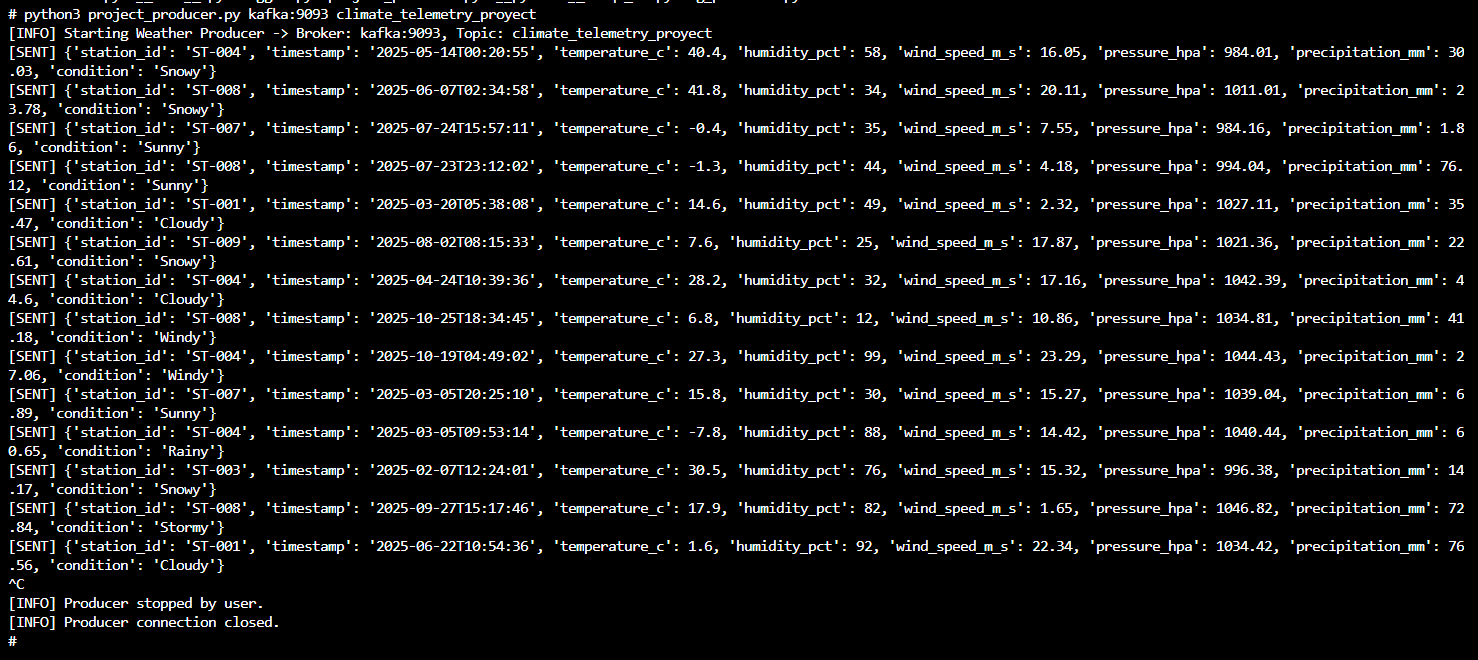

## Power BI

To load the parquets into Power BI, i generated a new project, in which i choose de load Data option and then click in the "more" option, then we choose the load folder, we browse the folder where the parquets are. Then we click in the transform data option, where we filter only the .parquet files, then we combine and load the data, power bi will show the real columns in the parquets. Finally when we can see the real columns of our data we click in the save and apply button.

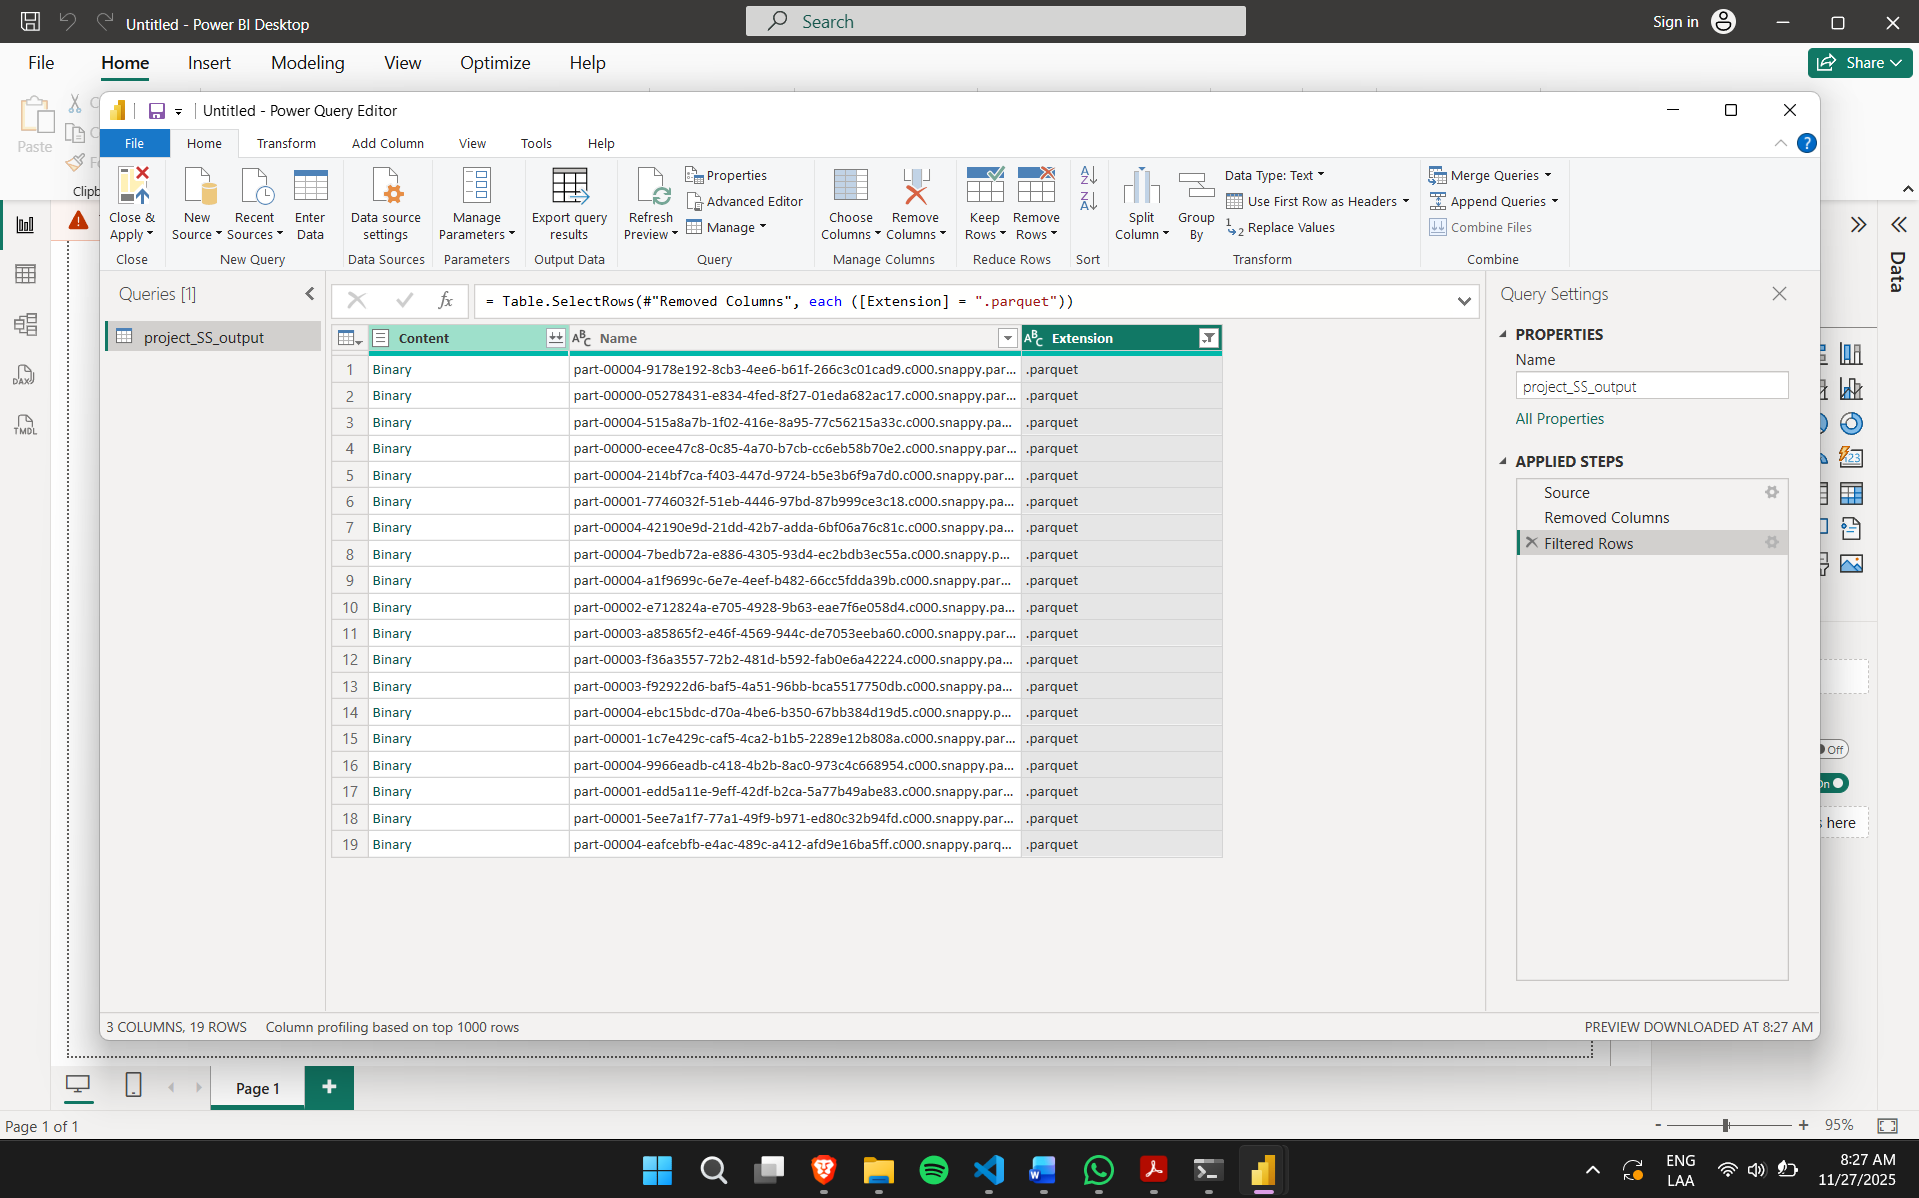

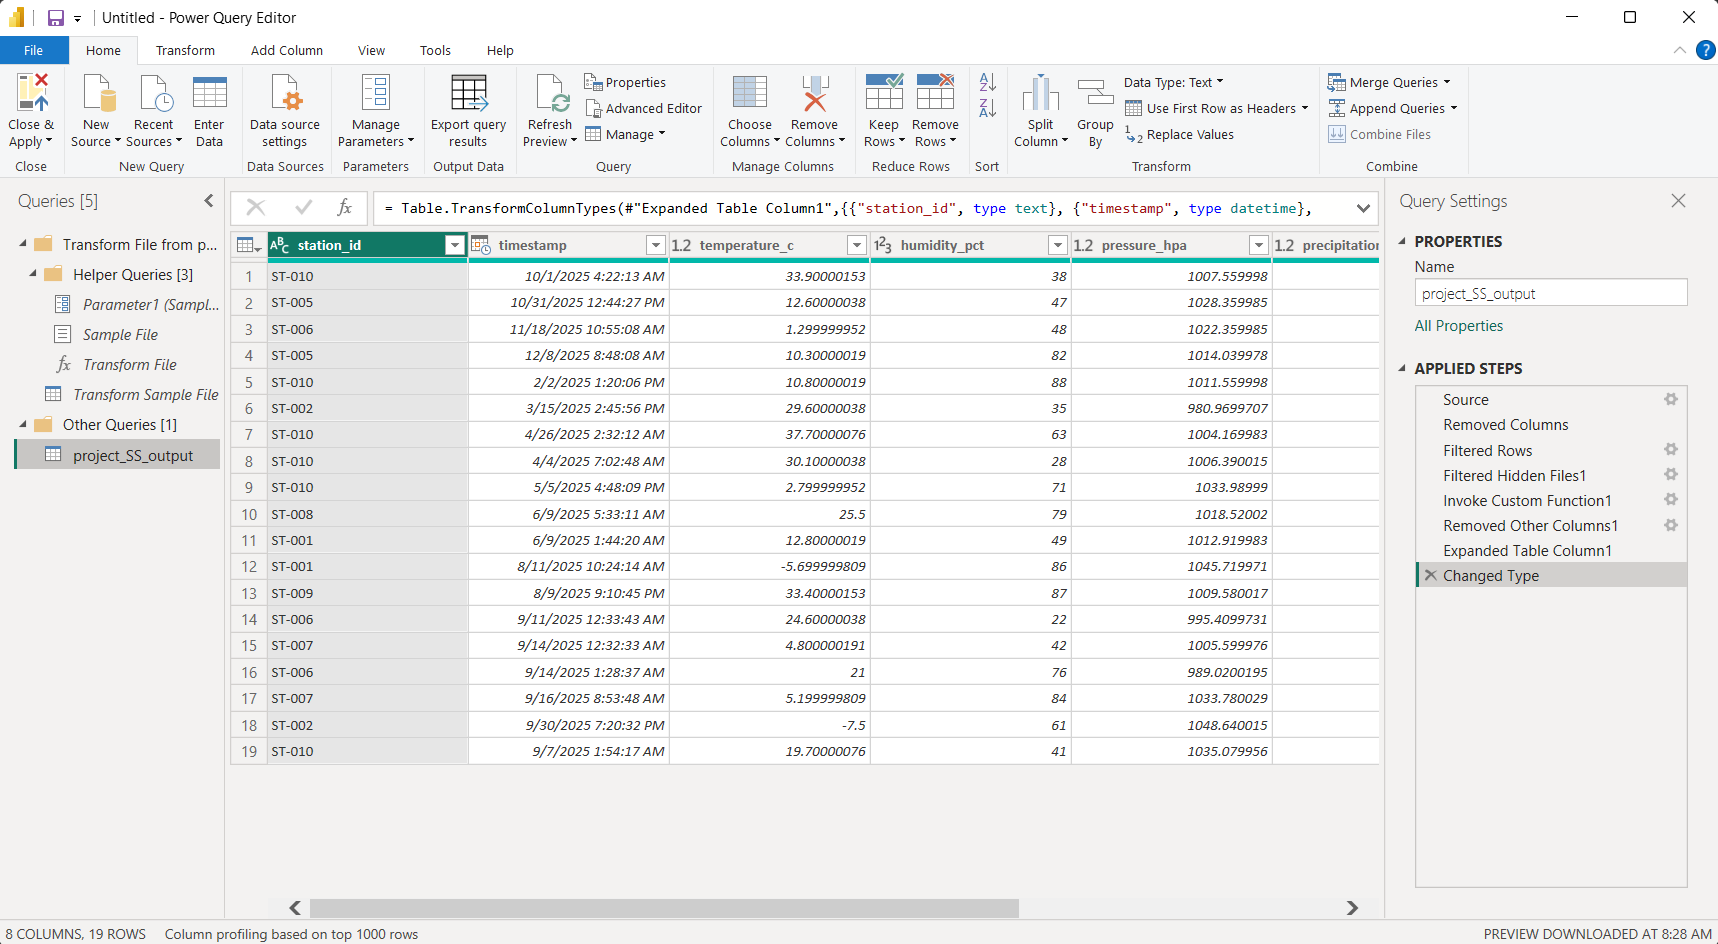

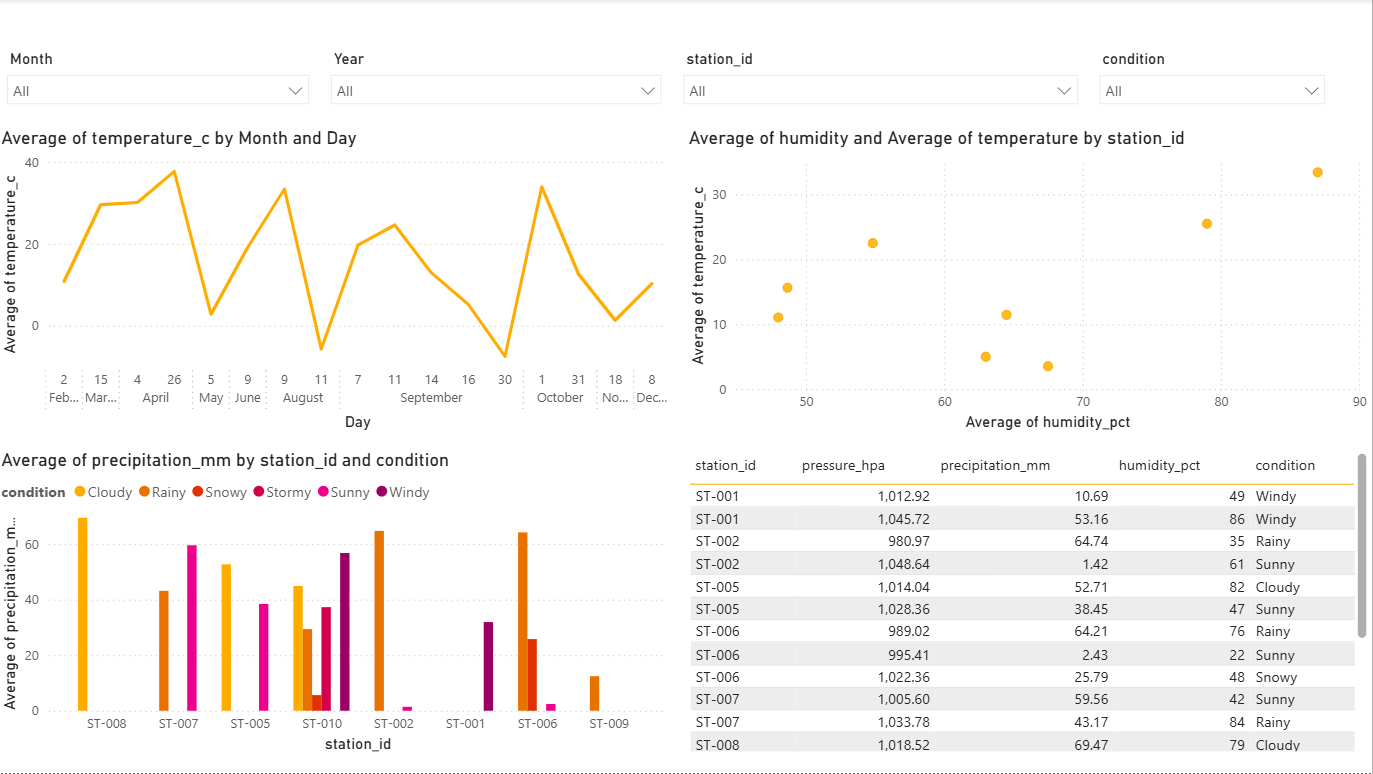